In [ ]:
from data import get_cell_dataloaders
import torch
from torch.utils.data import random_split, ConcatDataset
import segmentation_models_pytorch as smp
import numpy as np
import os
from train import train_model
from loss_functions import BCE_Dice_Loss
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import skimage
import cv2
from pprint import pprint

In [ ]:
FOLD_DIR = "/media/u1910100/Extreme SSD/data/tiger/cell_detection/dilation/patches/128"

test_fold = 1
print(f"Testing using fold {test_fold}")
train_loader, test_loader = get_cell_dataloaders(
    FOLD_DIR, fold_num=test_fold, batch_size=1, phase="Test"
)

print(len(test_loader.sampler))

In [ ]:
def imagenet_denormalise(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_normal = (img * std) + mean
    return img_normal

In [ ]:
model = smp.Unet(
    encoder_name="efficientnet-b0",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,  # model output channels (number of classes in your dataset)
)

model.load_state_dict(
    torch.load(
        "/home/u1910100/GitHub/TIAger-Torch/runs/cell_jaccard/fold_1/fold_1/model_final.pth"
    )
)

model.to("cuda")
model.eval()

In [ ]:
thresholds = [0.5]

for threshold in thresholds:
    sum_IOU = []
    sum_F1 = []
    sum_precison = []
    sum_recall = []
    print(f"threshold = {threshold}")
    # for i in range(0,5):
    for batch in tqdm(test_loader):
        batch = next(iter(test_loader))
        imgs, masks = batch["img"], batch["mask"]

        # img = batch["img"][0].numpy(force=True)
        # img = np.moveaxis(img, 0, 2)
        # img_normal = imagenet_denormalise(img)
        # fig, axs = plt.subplots(1, 3)
        # axs[0].imshow(img_normal)
        # axs[0].title.set_text("Image")
        # axs[1].imshow(masks[0][0], cmap='gray')
        # axs[1].title.set_text("Ground Truth")

        imgs = imgs.to("cuda").float()
        masks = masks.to("cuda").long()
        with torch.no_grad():
            out = model(imgs)
            out = torch.sigmoid(out)

        tp, fp, fn, tn = smp.metrics.get_stats(
            out, masks, mode="binary", threshold=threshold
        )
        iou_score = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro", zero_division=1
        )
        f1_score = smp.metrics.f1_score(
            tp, fp, fn, tn, reduction="micro", zero_division=1
        )
        precison_score = smp.metrics.precision(
            tp, fp, fn, tn, reduction="micro", zero_division=1
        )
        recall_score = smp.metrics.recall(
            tp, fp, fn, tn, reduction="micro", zero_division=1
        )

        iou_score = iou_score.cpu().detach().item()
        f1_score = f1_score.cpu().detach().item()
        precison_score = precison_score.cpu().detach().item()
        recall_score = recall_score.cpu().detach().item()

        if math.isnan(iou_score):
            iou_score = 1
        if math.isnan(f1_score):
            f1_score = 1
        if math.isnan(precison_score):
            precison_score = 1
        if math.isnan(recall_score):
            recall_score = 1

        # out = out.cpu().detach().numpy()[0][0]
        # out_mask = np.where(out >= threshold, 1, 0).astype(np.uint8)
        # axs[2].imshow(out_mask, cmap="gray")
        # axs[2].title.set_text("Prediction")
        # for ax in fig.axes:
        #     ax.axis("off")
        # plt.show()
        # print(f"IOU (Jaccard): {iou_score}")
        # print(f"F1 (Dice): {f1_score}")

        sum_IOU.append(iou_score)
        sum_F1.append(f1_score)
        sum_precison.append(precison_score)
        sum_recall.append(recall_score)

    # sum_IOU = np.array(sum_IOU)
    # sum_F1 = np.array(sum_F1)
    print("-------------")
    print("Avg Jaccard ", np.mean(sum_IOU))
    print("Avg Dice ", np.mean(sum_F1))
    print("Avg Precision ", np.mean(sum_precison))
    print("Avg Recall ", np.mean(sum_recall))

In [10]:
def get_cell_centers(cell_mask):
    mask_label = skimage.measure.label(cell_mask)
    stats = skimage.measure.regionprops(mask_label)
    centers = []
    for region in stats:
        centroid = region["centroid"]
        centers.append(centroid)
    return centers


def point_to_box(x, y, size):
    """Convert centerpoint to bounding box of fixed size"""
    return np.array([x - size, y - size, x + size, y + size])


def check_point_in_box(x, y, box):
    cond_1 = x >= box[0] and x <= box[2]
    cond_2 = y >= box[1] and y <= box[3]
    return cond_1 and cond_2


def check_point_in_circle(x, y, center_x, center_y, radius):
    dist = math.sqrt((center_x - x) ** 2 + (center_y - y) ** 2)
    # print(dist)
    return dist <= radius


def evaluate_cell_predictions(gt_centers, pred_centers):
    tp_x_coords = []
    tp_y_coords = []

    # print(f"Total gt cells: {len(gt_centers)}")
    # print(f"Total pred cells: {len(pred_centers)}")
    tp = 0
    fp = 0
    fn = 0

    for j, pred_center in enumerate(pred_centers):
        for i, true_center in enumerate(gt_centers):
            # true_box = point_to_box(true_center[0], true_center[1], 8)
            # if check_point_in_box(pred_center[0], pred_center[1], true_box):
            if check_point_in_circle(
                pred_center[0],
                pred_center[1],
                true_center[0],
                true_center[1],
                8,
            ):
                tp_x_coords.append(pred_center[0])
                tp_y_coords.append(pred_center[1])
                tp += 1
                del gt_centers[i]
                del pred_centers[j]
                break

    for i, true_center in enumerate(gt_centers):
        for j, pred_center in enumerate(pred_centers):
            # true_box = point_to_box(true_center[0], true_center[1], 8)
            # if check_point_in_box(pred_center[0], pred_center[1], true_box):
            if check_point_in_circle(
                pred_center[0],
                pred_center[1],
                true_center[0],
                true_center[1],
                8,
            ):
                tp_x_coords.append(pred_center[0])
                tp_y_coords.append(pred_center[1])
                tp += 1
                del gt_centers[i]
                del pred_centers[j]
                break

    fn = len(gt_centers)
    fp = len(pred_centers)

    try:
        precision = tp / (tp + fp)
    except ZeroDivisionError:
        precision = 1
    try:
        recall = tp / (tp + fn)
    except ZeroDivisionError:
        recall = 1
    try:
        f1 = (2 * precision * recall) / (precision + recall)
    except ZeroDivisionError:
        f1 = 1

    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"f1 = {f1}")
    print(f"precision = {precision}")
    print(f"recall = {recall}")

    return tp_x_coords, tp_y_coords, f1, precision, recall


def erode_mask(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.erode(mask, kernel, iterations=1)
    return mask

threshold = 0.9
True Positives: 4
False Positives: 0
False Negatives: 1
f1 = 0.888888888888889
precision = 1.0
recall = 0.8


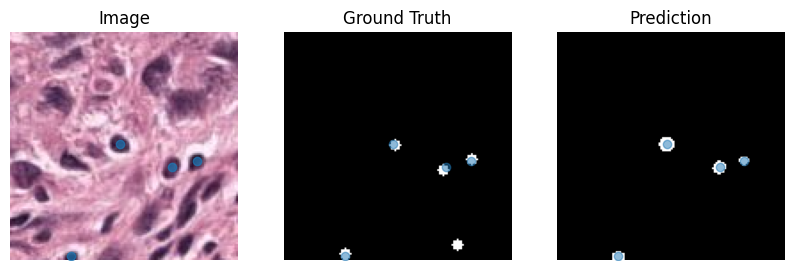

-------------
Avg F1  0.888888888888889
Avg Precision  1.0
Avg Recall  0.8


In [54]:
sum_IOU = []
sum_F1 = []
sum_precison = []
sum_recall = []
sum_Dice = []
threshold = 0.9
print(f"threshold = {threshold}")

# for batch in tqdm(test_loader):
for i in range(0, 1):
    batch = next(iter(test_loader))
    imgs, masks = batch["img"], batch["mask"]

    img = batch["img"][0].numpy(force=True)
    img = np.moveaxis(img, 0, 2)
    img_normal = imagenet_denormalise(img)
    fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    axs[0].imshow(img_normal)
    axs[0].title.set_text("Image")
    axs[1].imshow(masks[0][0], cmap="gray")
    axs[1].title.set_text("Ground Truth")

    imgs = imgs.to("cuda").float()
    masks = masks.to("cuda").long()
    with torch.no_grad():
        out = model(imgs)
        out = torch.nn.functional.sigmoid(out)

    tp, fp, fn, tn = smp.metrics.get_stats(
        out, masks, mode="binary", threshold=threshold
    )
    iou_score = smp.metrics.iou_score(
        tp, fp, fn, tn, reduction="micro", zero_division=1
    )
    f1_score = smp.metrics.f1_score(
        tp, fp, fn, tn, reduction="micro", zero_division=0
    )
    precison_score = smp.metrics.precision(
        tp, fp, fn, tn, reduction="micro", zero_division=1
    )
    recall_score = smp.metrics.recall(
        tp, fp, fn, tn, reduction="micro", zero_division=1
    )

    iou_score = iou_score.cpu().detach().item()
    f1_score = f1_score.cpu().detach().item()
    precison_score = precison_score.cpu().detach().item()
    recall_score = recall_score.cpu().detach().item()

    if math.isnan(iou_score):
        iou_score = 1
    if math.isnan(f1_score):
        f1_score = 1
    if math.isnan(precison_score):
        precison_score = 1
    if math.isnan(recall_score):
        recall_score = 1

    out = out.cpu().detach().numpy()
    out_mask = out[0][0]

    out_mask[out_mask >= threshold] = 1
    out_mask[out_mask < threshold] = 0

    pred_centers = get_cell_centers(out_mask)
    masks = masks.cpu().detach().numpy()[0][0].astype(np.uint8)
    true_centers = get_cell_centers(masks)
    xs, ys, f1, precision, recall = evaluate_cell_predictions(
        true_centers, pred_centers
    )

    axs[2].imshow(out_mask, cmap="gray")
    axs[2].title.set_text("Prediction")

    axs[0].scatter(ys, xs, alpha=0.7)
    axs[1].scatter(ys, xs, alpha=0.5)
    axs[2].scatter(ys, xs, alpha=0.5)

    for ax in fig.axes:
        ax.axis("off")
    plt.show()

    # print(f"IOU (Jaccard): {iou_score}")
    # print(f"F1 (Dice): {f1_score}")
    sum_Dice.append(f1_score)
    sum_IOU.append(iou_score)
    sum_F1.append(f1)
    sum_precison.append(precision)
    sum_recall.append(recall)

# sum_IOU = np.array(sum_IOU)
# sum_F1 = np.array(sum_F1)
print("-------------")
# print("Avg Jaccard ", np.mean(sum_IOU))
# print("Avg Dice ", np.mean(sum_Dice))
print("Avg F1 ", np.mean(sum_F1))
print("Avg Precision ", np.mean(sum_precison))
print("Avg Recall ", np.mean(sum_recall))